Setup
-----

- Import `numpy` and `matplotlib`.
- Define some helper functions.
  - `randunif`: Generate a random vector
  - `random_frame`: Generates a frame matrix. This gives us the frame vectors as well as the analysis/synthesis operators.
  - `gs_phaseless`: Does the Gerchberg-Saxton algorithm for a real vector.
  - `stemplot`: Plots the known solution with the retrieved vector.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def randunif(n, a=0, b=1, seed=None):
    '''
    Generate a uniform random vector
    '''
    rng = np.random.default_rng(seed) # random number generator
    return (b-a) * rng.random(n) + a  # uniform distribution


def random_frame(input_dimension, redundancy=2, frame_dimension=None, seed=None):
    '''
    Generate a matrix whose rows are frame vectors
    '''
    n = input_dimension
    if frame_dimension is None:
        m = int(input_dimension * redundancy)
    else:
        m = frame_dimension

    rng = np.random.default_rng(seed)
    rand_mat = rng.random((m,m))  # generate random matrix in m x m
    Q, _ = np.linalg.qr(rand_mat) # get orthonormal basis in Rm
    return Q[:,:n]                # get m x n frame matrix


def gs_phaseless(magnitude, frame, num_iter=200, seed=None):
    '''
    Gerchberg-Saxton phaseless retrieval.

    x(i) -> X(i) -> Y(i) -> y(i) -> x(i+1)
    - x(i)                         : current approximation
    - X(i) = F x(i)                : analysis projection
    - Y(i) = C1 X(i)               : frame-domain constraint
    - y(i) = F* Y(i)               : synthesis projection
    - x(i+1) = MinErr{y(i), -y(i)} : new approximation
    '''
    # make sure magnitudes and frames are formatted nicely
    b = np.asarray(magnitude)
    F = np.asarray(frame)
    # get frame dimensions
    n = F.shape[1]
    # get random guess
    x0 = randunif(n, -1, 1, seed=seed)
    # projection error function
    err = lambda z : np.linalg.norm(np.abs(F.dot(z)) - magnitude)

    # do GS iterations
    for i in range(num_iter):
        # project with analysis operator
        X0 = F @ x0
        # assert magnitude for estimated phase (sign)
        Y0 = b * np.exp(1j * np.angle(X0))
        # reconstruct with synthesis operator
        y0 = F.T @ Y0
        # get x0 with minimum error
        x0 = y0 if err(y0) < err(-y0) else -y0
        # real condition
        x0 = np.real(x0)
    return x0

def stemplot(x, x0, xlabel="original", x0label="retrieved"):
    n = np.shape(x)[0]
    ii = np.linspace(0,1,n)
    plt.stem(ii, x, label=xlabel)
    plt.stem(ii, x0,':r', label=x0label)
    plt.legend()
    plt.show()

Main Routine
------------
1. Choose dimension $n$ of input space.
2. Choose redundancy $r$.
3. Generate the vector $x = [x_1, x_2, \dots, x_n]^\top \in \mathbb{R}^n$ we are trying to reconstruct.
4. Generate a random frame $(f_i)_{i=1}^n$.
5. Get the magnitude measurements along the frame vectors $b_j = \left|\sum_{i=1}^n \langle x_i, f_{ij} \rangle\right|$.
6. Do the GS algorithm to estimate $x$.
7. Compute error and plot solution against known vector.

Right now, this method is only converging for redundancy $r > \frac{3}{4}n$.
I think this is because we are reducing error at every iteration.
In this situation, our solution gets stuck in a local minimum.
Other algorithms apply a weight parameter to pull the solution away from these local minima.

Approximation error: 9.800562044244752e-16


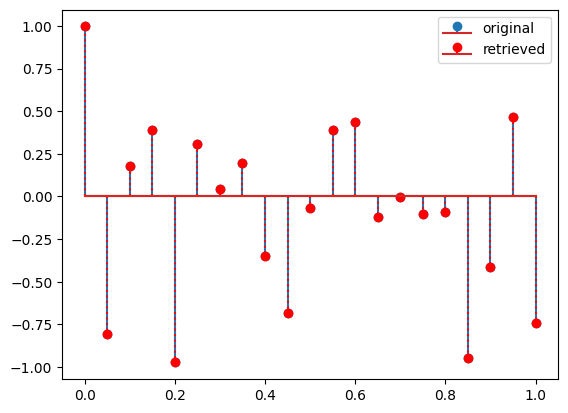

In [2]:
# dimension of input space
n = 21
# frame redundancy
r = n/2 + 5
# r = n/2 # uncomment to see the problem with redundancy
# frame dimension
m = int(r*n)

# generate random vector
x = randunif(n, -1, 1, seed=1231)
# generate random frame
F = random_frame(n, r, seed=1121)
# get known magnitude measurements wrt frame
magnitude = np.abs(F.dot(x))

# do phase retrieval
x0 = gs_phaseless(magnitude, F, seed=4321)
# compute errors
err_pos = np.linalg.norm(x-x0)
err_neg = np.linalg.norm(x+x0)
# fix sign
x0 = -x0 if err_neg < err_pos else x0
err = np.min([err_pos, err_neg])
print(f"Approximation error: {err}")

# plot
stemplot(x, x0)